In [3]:
import keras
import json
import pandas as pd
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Lambda, Reshape
from keras.utils import plot_model
from matplotlib import pyplot as plt
import random
import numpy as np

In [4]:
with open('business.json') as file:
    data = [json.loads(line) for line in file]
with open('photo.json') as file:
    photos = [json.loads(line) for line in file]

In [5]:
df = pd.DataFrame(data)
restaurants = df[df['categories'].str.contains('Restaurants').fillna(False)]
restaurants = restaurants[restaurants['review_count'] >= 50]
in_restaurants = {restaurants['business_id'].iloc[i] : True for i in range(len(restaurants))}

random.seed(0)
random.shuffle(photos)

In [6]:
MAX = 2000
high = 4.5
low = 2.5
X, y = [], [] 

count = [0, 0]
for photo in photos:
    if len(X) >= MAX:
        break
    name, photo_id = photo['business_id'], photo['photo_id']
    if photo['label'] != 'food' or name not in in_restaurants.keys():
        continue
    rating = restaurants[restaurants['business_id'] == name]['stars'].iloc[0]
    if (rating < high and rating > low) or count[int(rating >= high)] >= MAX/2:
        continue
    count[int(rating >= high)] += 1
    photo_array = imread('photos/' + photo_id + '.jpg')
    resized = resize(photo_array, (128, 128, 3), anti_aliasing = True)
    X.append(resized)
    y.append(float(rating >= high))
    
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

/home/mbper/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
def construct():
    image = Input(shape=(128, 128, 3))

    x1 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(image)
    x2 = MaxPooling2D(pool_size=2)(x1)
    x3 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(x2)
    x4 = MaxPooling2D(pool_size=2)(x3)
    x5 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(x4)
    encoded = MaxPooling2D(pool_size=2)(x5)

    y1 = UpSampling2D(size=2)(encoded)
    y2 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(y1)
    y3 = UpSampling2D(size=2)(y2)
    y4 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(y3)
    y5 = UpSampling2D(size=2)(y4)
    reconstructed = Conv2D(3, 3, strides=1, padding='same', activation = 'sigmoid')(y5)

    z1 = Conv2D(64, 3, strides=1, padding='same')(encoded)
    z2 = MaxPooling2D(pool_size=2)(z1)
    z3 = Conv2D(64, 3, strides=1, padding='same')(z2)
    z4 = MaxPooling2D(pool_size=2)(z3)
    z5 = Flatten()(z4)
    z6 = Dense(128, activation='relu')(z5)
    rating = Dense(1, activation='sigmoid')(z6)
    
    return (image, reconstructed, rating)

In [8]:
image, reconstructed, rating = construct()

autoencoder = Model(inputs = image, outputs = reconstructed)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
for layer in autoencoder.layers:
    layer.trainable = False
predictor = Model(inputs = image, outputs = rating)
predictor.compile(optimizer='adadelta', loss='binary_crossentropy')
mixed = Model(inputs = image, outputs = [rating, reconstructed])
mixed.compile(optimizer='adadelta', loss=['binary_crossentropy', 'mean_squared_error'], loss_weights = [1., 100.])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Fit the autoencoder, then freeze the layers
autoencoder.fit(X_train, X_train, batch_size=20, epochs=3)
predictor.fit(X_train, y_train, batch_size=20, epochs=8)

Instructions for updating:
Use tf.cast instead.


/home/mbper/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/3
1600/1600 [==============================] - 90s 56ms/step - loss: 0.0599
Epoch 2/3
1600/1600 [==============================] - 86s 54ms/step - loss: 0.0295
Epoch 3/3
1600/1600 [==============================] - 88s 55ms/step - loss: 0.0222
Epoch 1/8
1600/1600 [==============================] - 12s 8ms/step - loss: 0.6857
Epoch 2/8
1600/1600 [==============================] - 14s 9ms/step - loss: 0.6342
Epoch 3/8
1600/1600 [==============================] - 10s 6ms/step - loss: 0.5761
Epoch 4/8
1600/1600 [==============================] - 10s 6ms/step - loss: 0.4995
Epoch 5/8
1600/1600 [==============================] - 11s 7ms/step - loss: 0.4132
Epoch 6/8
1600/1600 [==============================] - 10s 6ms/step - loss: 0.3291
Epoch 7/8
1600/1600 [==============================] - 10s 6ms/step - loss: 0.2048
Epoch 8/8
1600/1600 [==============================] - 11s 7ms/step - loss: 0.1116


In [10]:
predictions = np.round(predictor.predict(X_test))
accuracy = sum([y_test[i] == predictions[i] for i in range(len(predictions))])/len(y_test)
print(accuracy)

[0.705]


In [10]:
image, reconstructed, rating = construct()

autoencoder = Model(inputs = image, outputs = reconstructed)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
predictor = Model(inputs = image, outputs = rating)
predictor.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
# Fit the autoencoder, but don't freeze the layers
autoencoder.fit(X_train, X_train, batch_size=20, epochs=3)
predictor.fit(X_train, y_train, batch_size=20, epochs=8)

Epoch 1/3
1600/1600 [==============================] - 82s 51ms/step - loss: 0.0585
Epoch 2/3
1600/1600 [==============================] - 83s 52ms/step - loss: 0.0267
Epoch 3/3
1600/1600 [==============================] - 79s 49ms/step - loss: 0.0217
Epoch 1/8
1600/1600 [==============================] - 30s 19ms/step - loss: 0.6901
Epoch 2/8
1600/1600 [==============================] - 29s 18ms/step - loss: 0.6507
Epoch 3/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.6205
Epoch 4/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.5688
Epoch 5/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.5117
Epoch 6/8
1600/1600 [==============================] - 28s 17ms/step - loss: 0.4167
Epoch 7/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.3141
Epoch 8/8
1600/1600 [==============================] - 26s 17ms/step - loss: 0.1680


In [14]:
predictions = np.round(predictor.predict(X_test))
accuracy = sum([y_test[i] == predictions[i] for i in range(len(predictions))])/len(y_test)
print(accuracy)

[0.6825]


In [15]:
image, reconstructed, rating = construct()

predictor = Model(inputs = image, outputs = rating)
predictor.compile(optimizer='adadelta', loss='binary_crossentropy')
for layer in predictor.layers:
    layer.trainable = False
autoencoder = Model(inputs = image, outputs = reconstructed)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [16]:
predictor.fit(X_train, y_train, batch_size=20, epochs=8)
autoencoder.fit(X_train, X_train, batch_size=20, epochs=3)

Epoch 1/8
1600/1600 [==============================] - 31s 19ms/step - loss: 0.6957
Epoch 2/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.6698
Epoch 3/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.6479
Epoch 4/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.6129
Epoch 5/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.5792
Epoch 6/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.5402
Epoch 7/8
1600/1600 [==============================] - 27s 17ms/step - loss: 0.4744
Epoch 8/8
1600/1600 [==============================] - 28s 17ms/step - loss: 0.3681
Epoch 1/3
1600/1600 [==============================] - 64s 40ms/step - loss: 0.0464
Epoch 2/3
1600/1600 [==============================] - 61s 38ms/step - loss: 0.0267
Epoch 3/3
1600/1600 [==============================] - 61s 38ms/step - loss: 0.0238


In [19]:
predictions = np.round(predictor.predict(X_test))
accuracy = sum([y_test[i] == predictions[i] for i in range(len(predictions))])/len(y_test)
print(accuracy)

[0.725]


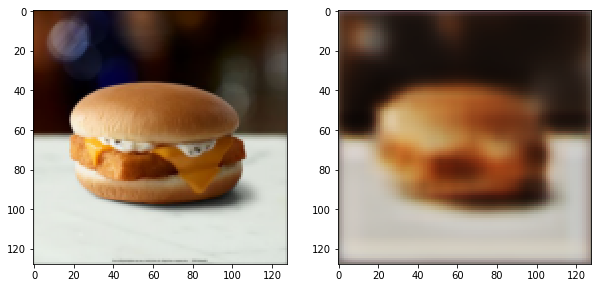

In [12]:
N = 3
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(X_test[N])
ax2.imshow(autoencoder.predict(X_test[N:N+1])[0])
fig.show()